# Aufgabe 3 - Datenvorverarbeitung

In [79]:
#Importieren der Bibliotheken und des Datensatzes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob as glob


ep_list = []
ep_pfad = glob.glob('data_v2/data_train_set/episode_*.csv')

for ep in ep_pfad:
    ep_list.append(pd.read_csv(ep, sep=';', decimal=','))



In [80]:
#Datenpunkte zählen

dp_zeilen = 0
dp_zellen = 0

for i, ep in enumerate(ep_list):
    dp_zeilen += len(ep)
    dp_zellen += ep.size

print(f'Es wurden {len(ep_list)} Episoden aufgezeichnet.')
print(f'Insgesamt gibt es {dp_zeilen} Datenzeilen.')
print(f'Komplette Anzahl der Datenpunkte: {dp_zellen}')

Es wurden 198 Episoden aufgezeichnet.
Insgesamt gibt es 27710 Datenzeilen.
Komplette Anzahl der Datenpunkte: 775880


### 3.2 Filtern nach erfolgreichem Episoden

Eine Episode ist dann erfolgreich, wenn die Reward-Spalte in der letzten Zeile den Wert 1 hat, d.h. der Stecker wurde erfolgreich eingesteckt.

In [81]:
#Filtern nach erfolgreichem Episoden
ep_list_erfolgreich = []
for ep in ep_list:
    if ep['reward'].iloc[-1] == 1: #Prüfen, ob die letzte Zeile in der reward Spalte 1 ist
        ep_list_erfolgreich.append(ep)

print(f'Es gibt {len(ep_list_erfolgreich)} erfolgreiche Episoden.')
print(f'{len(ep_list_erfolgreich)/len(ep_list):.2%} der Episoden waren erfolgreich.')

Es gibt 159 erfolgreiche Episoden.
80.30% der Episoden waren erfolgreich.


In [82]:
#Fehlende Werte auffüllen
for i, ep in enumerate(ep_list_erfolgreich):
    ep_list_erfolgreich[i] = ep.interpolate(method='linear').ffill().bfill()

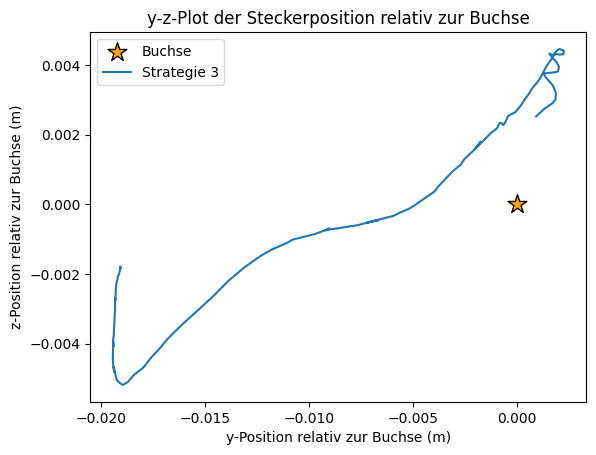

In [83]:
#Welceh Suchstrategie wurde verwendet?
i = 100 #Ep Nummer

#Buchse als Referenzpunkt festlegen
y_buchse = 0
z_buchse = 0

#Relative Position zum Buchsenmittelpunkt festlegen
y_rel = ep_list_erfolgreich[i]['current_absolute_pose_y'] - 0.14
z_rel = ep_list_erfolgreich[i]['current_absolute_pose_z'] - 0.55

#Plott zeigt Suchstrategie 3
plt.scatter(y_buchse, z_buchse, c='orange', marker='*', edgecolors='black', s=200, label='Buchse')
plt.plot(y_rel, z_rel, label='Strategie 3')
plt.xlabel('y-Position relativ zur Buchse (m)')
plt.ylabel('z-Position relativ zur Buchse (m)')
plt.title('y-z-Plot der Steckerposition relativ zur Buchse')
plt.legend()
plt.show()

### 3.4 Welche Suchstrategie wurde verwendet?
Im Trainingsdatensatz wurde Strategie 3 verwendet. Erkennbar an der kontinuierlichen Annäherung des Steckers an die Buchse, gefolgt von einem lokalen Kreisen um den Buchsenmittelpunkt. Das gezitterte Verhalten am Ende deutet darauf hin, dass die Strategie versucht, Rotation und Neigung des Steckers zu korrigieren, um das Einstecken zu ermöglichen.

In [84]:
#Value berechnen
gamma = 0.999

#Schleife über alle erfolgreichen Episoden, um die Value-Spalte zu berechnen
for i, ep in enumerate(ep_list_erfolgreich):
    T = len(ep)
    value = gamma ** np.arange(T-1, -1, -1) #Berechnung der Value
    ep_list_erfolgreich[i]['value'] = value #Speichern der Value-Spalte in der DataFrame

ep_list_erfolgreich[10][['reward','value']].tail(-1)


,reward,value
1,0.0,0.893100
2,0.0,0.893994
3,0.0,0.894889
4,0.0,0.895785
5,0.0,0.896682
...,...,...
110,0.0,0.996006
111,0.0,0.997003
112,0.0,0.998001
113,0.0,0.999000


Mittelwert der Values zu Beginn der Episoden: 0.9163


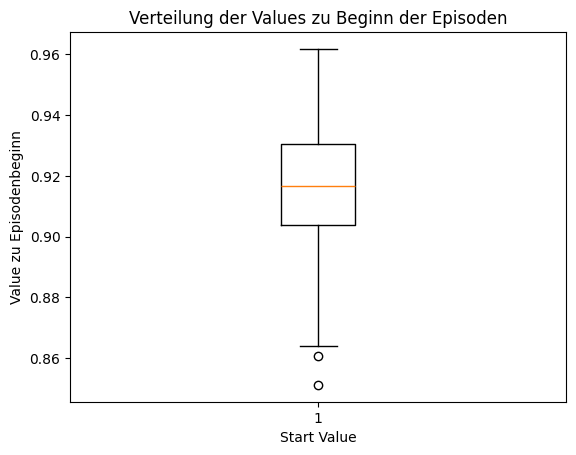

In [85]:
#Mittelwert der Values zu begin der episoden berechnen
start_values = [ep['value'].iloc[0] for ep in ep_list_erfolgreich]
mean_start_value = np.mean(start_values)
print(f'Mittelwert der Values zu Beginn der Episoden: {mean_start_value:.4f}')

#Plotten der Value-Verteilung zu Beginn der Episoden
plt.boxplot(start_values)
plt.xlabel('Start Value')
plt.ylabel('Value zu Episodenbeginn')
plt.title('Verteilung der Values zu Beginn der Episoden')
plt.show()

Ausreißer in plt.boxplot sind definiert als Datenpunkte, die mehr als das 1,5-fache des Interquartilsabstands (IQR) vom ersten oder dritten Quartil entfernt liegen. Der IQR ist die Differenz zwischen Q3 und Q1. Die Grenzen sind: untere Grenze = Q1 − 1,5 · IQR und obere Grenze = Q3 + 1,5 · IQR.

In [86]:
#Ausreißer in ep identifizieren und entfernen

#Berechnung des IQR
Q1 = np.percentile(start_values, 25)
Q3 = np.percentile(start_values, 75)
IQR = Q3 - Q1

#Definieren der unteren und oberen Grenzen für Ausreißer
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1 -> 25%: {Q1:.4f}")
print(f"Q3 -> 75%: {Q3:.4f}")
print(f"IQR: {IQR:.4f}")
print(f"Untere Grenze: {lower_bound:.4f}")
print(f"Obere Grenze: {upper_bound:.4f}")

# Identifiziere Ausreißer
outlier = []
for i, val in enumerate(start_values):
    if val < lower_bound or val > upper_bound:
        outlier.append(i)

num_outliers = len(outlier)
print(f"\nAnzahl der Ausreißer: {num_outliers}")

#Rausfiltern der Ausreißer
ep_list_gefiltert = [ep for i, ep in enumerate(ep_list_erfolgreich) if i not in outlier]

print(f'Episoden vor dem Filtern: {len(ep_list_erfolgreich)}')
print(f'Episoden nach dem Filtern: {len(ep_list_gefiltert)}')

Q1 -> 25%: 0.9039
Q3 -> 75%: 0.9305
IQR: 0.0266
Untere Grenze: 0.8640
Obere Grenze: 0.9704

Anzahl der Ausreißer: 2
Episoden vor dem Filtern: 159
Episoden nach dem Filtern: 157


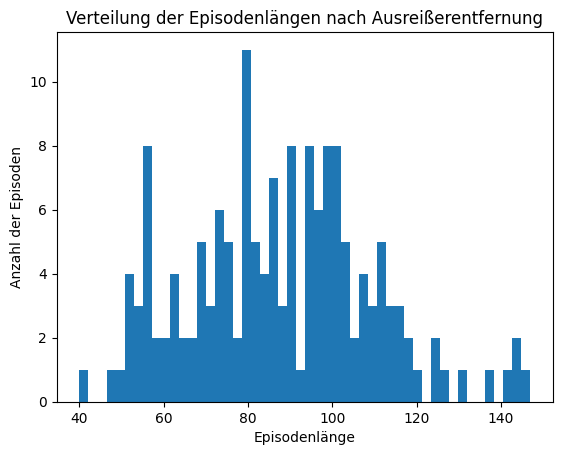

Es gibt 20 Episoden mit weniger als 60 Schritten.
Es gibt 10 Episoden mit mehr als 120 Schritten.
Die Kürzeste Episode hat 40 Schritte, die längste Episode hat 147 Schritte.


In [87]:
#Berechnung der Episodenlängen
ep_laengen = [len(ep) for ep in ep_list_gefiltert]

#Plotten der Verteilung der Episodenlängen
plt.hist(ep_laengen, bins=50)
plt.title('Verteilung der Episodenlängen nach Ausreißerentfernung')
plt.xlabel('Episodenlänge')
plt.ylabel('Anzahl der Episoden')
plt.show()

print(f'Es gibt {sum(1 for l in ep_laengen if l < 60)} Episoden mit weniger als 60 Schritten.')
print(f'Es gibt {sum(1 for l in ep_laengen if l > 120)} Episoden mit mehr als 120 Schritten.')
print(f'Die Kürzeste Episode hat {min(ep_laengen)} Schritte, die längste Episode hat {max(ep_laengen)} Schritte.')

In [88]:
#Zusammenführen der gefilterten Episoden zu einem Dataframe
df_gefiltert = pd.concat(ep_list_gefiltert, ignore_index=True)

In [89]:
#Speichern des gefilterten Datafram als CSV-Datei
df_gefiltert.to_csv('dataset.csv', index=False)